In [23]:
# 余分な Warning を非表示にする
import warnings

warnings.filterwarnings('ignore')

# Library の Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# matplotlib 日本語化対応
import japanize_matplotlib

# 表示 Option の調整
np.set_printoptions(suppress=True, precision=4)  # NumPy の浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format  # pandas での浮動小数点の表示精度
pd.set_option('display.max_columns', None)  # DataFrame ですべての項目を表示
plt.rcParams['font.size'] = 14  # Graph の Default font 指定
random_seed = 123  # 乱数の種

## 乳がん疾患 Dataset を取得して、Data 分割を行なう

In [5]:
# Data の Load
cancer = load_breast_cancer()

# 入力 Data x
x = cancer.data
x
# 正解 Data y
# 良性: 0, 悪性: 1 に値を変更する
y = 1 - cancer.target

# 入力 Data を２次元に絞り込み
x2 = x[:, :2]

# Data 分割
x_train, x_test, y_train, y_test = train_test_split(x2, y, train_size=0.7, test_size=0.3, random_state=random_seed)

## Algorithm を選択し評価する

In [6]:
# Algorithm 選択から評価まで

# Algorithm 選択（Logistic 回帰）
algorithm = LogisticRegression(random_state=random_seed)

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

# 評価
score = algorithm.score(x_test, y_test)

# 結果確認
print(f'score: {score:.4f}')

score: 0.8772


## 混合行列の作成

In [7]:
# 混合行列の計算

# 混合行列の生成
# y_test: 検証 Data の正解 Data
# y_pred: 検証 Data の予測結果
matrix = confusion_matrix(y_test, y_pred)

# 結果確認
print(matrix)

[[101   2]
 [ 19  49]]


## 視認性の高い混合行列を表示させる関数の定義

In [8]:
# 混合行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy 配列

    # columns 項目 List
    n = len(columns)

    # 正解 Data を n 回繰り返す List 生成
    act = ['正解 Data'] * n
    pred = ['予測結果'] * n

    # DataFrame 生成
    cm = pd.DataFrame(matrix, columns=[pred, columns], index=[act, columns])
    return cm

In [9]:
# make_cm を使った混合行列の表示
cm = make_cm(matrix, ['良性', '悪性'])
display(cm)

予測結果    
             良性  悪性
正解 Data 良性  101   2
        悪性   19  49

## 適合率・再現率・F 値の計算

In [10]:
# 適合率・再現率・F 値の計算
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)

# 結果の確認
print(f'適合率: {precision: .4f}')
print(f'再現率: {recall: .4f}')
print(f'F 値: {fscore: .4f}')

適合率:  0.9608
再現率:  0.7206
F 値:  0.8235


## 確率値と閾値

In [11]:
# 確率値の取得
y_proba = algorithm.predict_proba(x_test)
print(y_proba[:10, :])

[[0.9925 0.0075]
 [0.9981 0.0019]
 [0.0719 0.9281]
 [0.8134 0.1866]
 [0.0345 0.9655]
 [0.6376 0.3624]
 [0.9694 0.0306]
 [0.9743 0.0257]
 [0.76   0.24  ]
 [0.9775 0.0225]]


In [12]:
# positive(1)の確率値の取得
y_proba1 = y_proba[:, 1]

# 結果確認
print(y_test[10:20])
print(y_pred[10:20])
print(y_proba1[10:20])

[0 1 1 0 1 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0]
[0.2111 0.9188 0.1617 0.0609 0.631  0.0549 0.0601 0.0506 0.0383 0.0164]


In [13]:
# 閾値を変化させる
thres = 0.5
print((y_proba1[10:20] > thres).astype(int))

thres = 0.7
print((y_proba1[10:20] > thres).astype(int))

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


In [14]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
    # 確率値の取得
    y_proba = algorithm.predict_proba(x)

    # 予測結果１の確率値
    y_proba1 = y_proba[:, 1]

    # 予測結果１の確率値 > 閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [15]:
# 閾値 0.5 で予測結果取得
pred_05 = pred(algorithm, x_test, 0.5)

# 閾値 0.7 で予測結果取得
pred_07 = pred(algorithm, x_test, 0.7)

# 結果確認
print(pred_05[10:20])
print(pred_07[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


In [16]:
# 適合率、制限率、閾値の取得
# scikit-learn の precision_recall_curve 関数で正解 Data y_test と予測の確率値 y_proba1 を引数に手企業率、再現率とその時の閾値の配列で取得する。
precision, recall, thresholds = precision_recall_curve(y_test, y_proba1)

# 結果を DataFrame にする
df_pr = pd.DataFrame([thresholds, precision, recall]).T # DataFrame 化した後に「T」という Property で転置行列する。
df_pr.columns = ['閾値', '適合率', '再現率'] # 列 Title を追加する。

# 閾値 0.5 の周辺を表示
display(df_pr[52:122:10]) # 閾値0.5の時を含む行を10行刻みで抽出し表紙する。

,閾値,適合率,再現率
52,0.1473,0.7901,0.9412
62,0.2027,0.8310,0.8676
72,0.3371,0.9344,0.8382
82,0.5347,0.9608,0.7206
92,0.7763,0.9756,0.5882
102,0.9025,1.0000,0.4559
112,0.9829,1.0000,0.3088


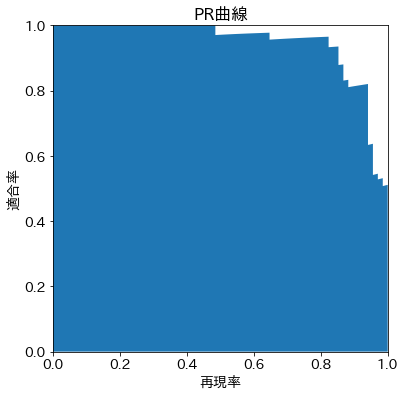

In [19]:
# 描画 Size 指定
plt.figure(figsize=(6,6))
# Graph 領域の塗りつぶし
plt.fill_between(recall, precision, 0)
# x, y の範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# Label, Title 表示
plt.xlabel('再現率')
plt.ylabel('適合率')
plt.title('PR曲線')
plt.show()

In [22]:
# PR 曲線下面積の計算
pr_auc = auc(recall, precision)
print(f'PR曲線下面積: {pr_auc:.4f}')

PR曲線下面積: 0.9459


## ROC 曲線

In [24]:
# ROC 曲線用配列の生成

# 偽陽性率、敏感度と閾値の取得
fpr, tpr, thresholds = roc_curve(y_test, y_proba1, drop_intermediate=False)

# 結果を DataFrame にする
df_roc = pd.DataFrame([thresholds, fpr, tpr]).T
df_roc.columns = ['閾値', '偽陽性率', '敏感度']

# 閾値0.5の周辺を表示
display(df_roc[21:91:10])

,閾値,偽陽性率,敏感度
21,0.9829,0.0000,0.3088
31,0.9025,0.0000,0.4559
41,0.7763,0.0097,0.5882
51,0.5347,0.0194,0.7206
61,0.3371,0.0388,0.8382
71,0.2027,0.1165,0.8676
81,0.1473,0.1650,0.9412
